# Experiment #1: Query Engineering
Started: 2025-01-16

In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from mutagenicity_dataset import *
from feature_engineering.node_features import *

/home/vlad/anaconda3/envs/vip_graphs/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1729805341246/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [3]:
### LOAD DATASET ###
data_path = './data'
transform = get_combined_mapping_transform()
dataset = TUDataset(root=data_path, name='Mutagenicity', transform=transform)

In [4]:
### CONVERT TO NETWORKX ###
dataset_nx = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    dataset_nx.append(G)
dataset_nx = np.array(dataset_nx, dtype=nx.classes.graph.Graph)

100%|██████████| 4337/4337 [00:01<00:00, 2477.71it/s]


In [5]:
# data = dataset[2]
# g = to_networkx(data, node_attrs=['x'], to_undirected=True)
# nx.draw(g)

# print(data.y.item())
# print(data.x)
# print(data.graph_class_label)
# print(data.node_feature_labels)
# print(data.edge_feature_labels)

## Feature Creation

In [5]:
# Create list of empty feature dictionaries for each data sample
feature_list = []  
for i in range(len(dataset)):
    feature_list.append({})

### Atom Type Count

In [6]:
atom_types = list(get_node_feature_label_mapping().values())

# Create features
count_dict = {}
for atom in atom_types:
    for i, data in enumerate(dataset):
        feature_list[i][f'{atom}_count'] = count_atom_type(data, atom)      

KeyboardInterrupt: 

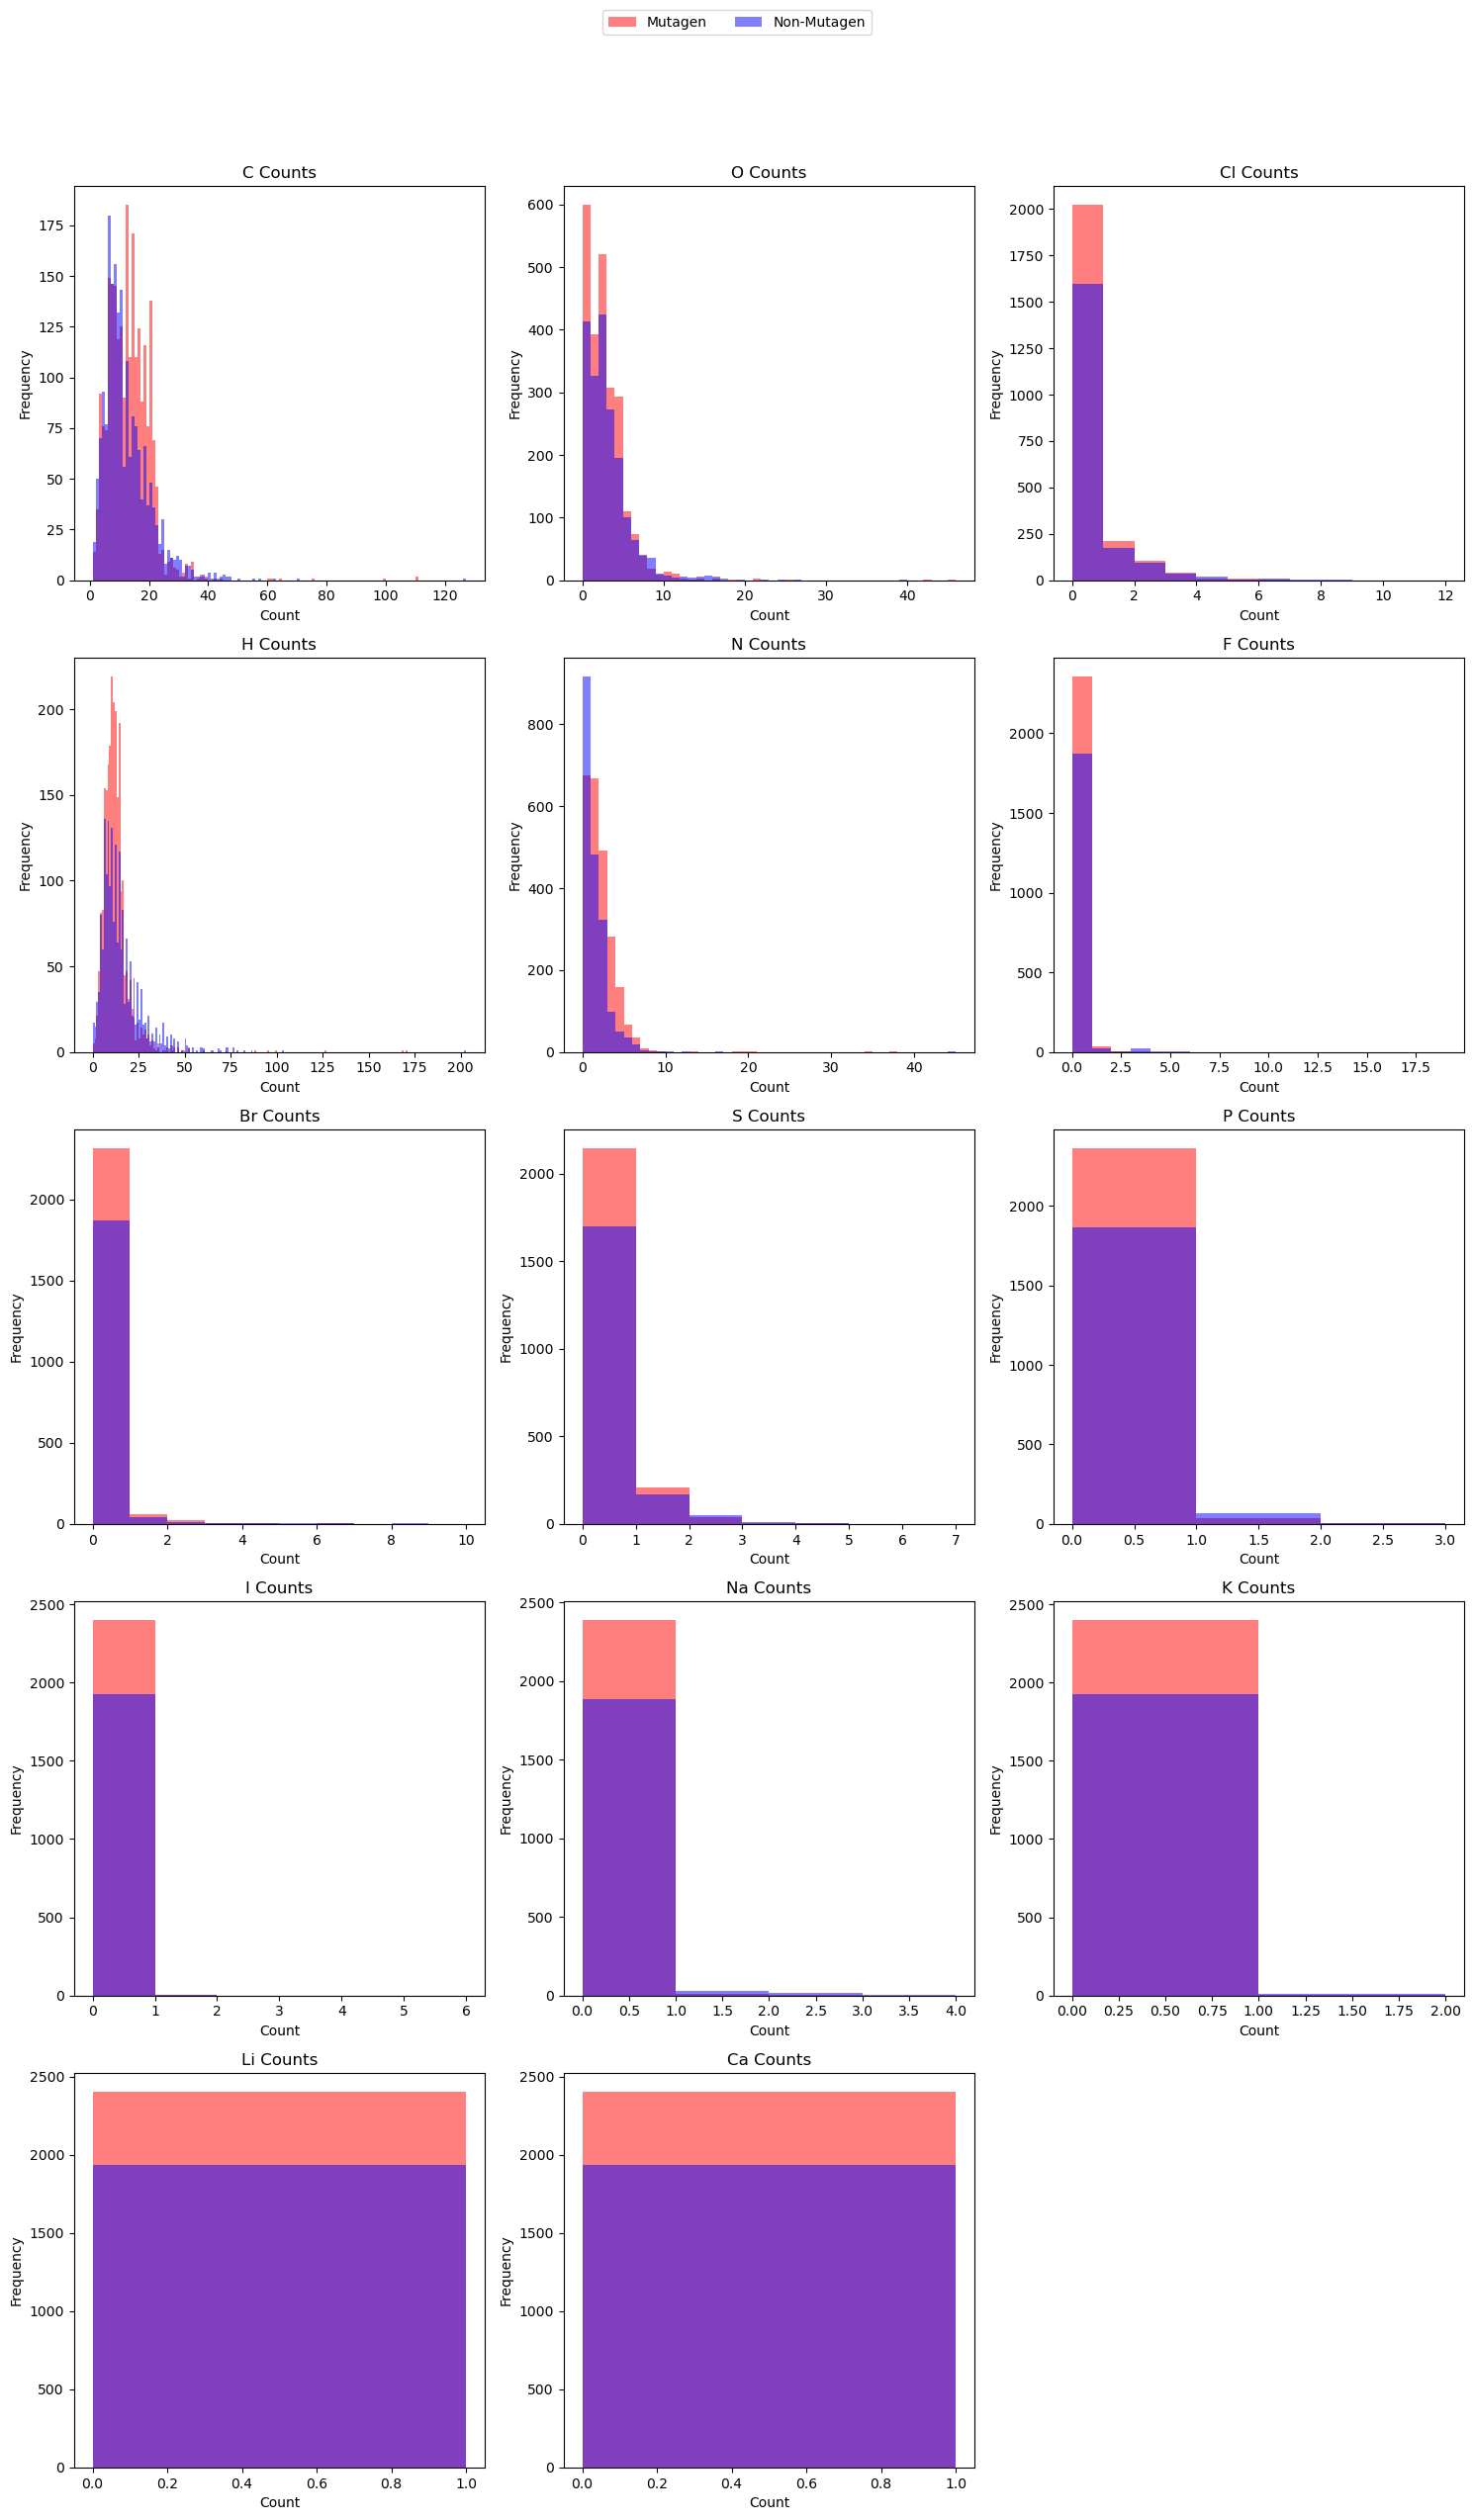

In [8]:
# Visualize features
ncols = 3
nrows = (len(atom_types) // ncols) + ((len(atom_types) % ncols) > 0)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axs = axs.flatten()

legend_handles = None
legend_labels = None
for idx, atom in enumerate(atom_types):
    mutagen_values = [features[f'{atom}_count'] for i, features in enumerate(feature_list) if dataset[i].mutagenicity == 'mutagen']
    nonmutagen_values = [features[f'{atom}_count'] for i, features in enumerate(feature_list) if dataset[i].mutagenicity == 'nonmutagen']
    
    joined = mutagen_values + nonmutagen_values
    min_count = min(joined)
    max_count = max(joined)

    ax = axs[idx]
    ax.hist(mutagen_values, bins=range(min_count, max_count + 1), align='mid', alpha=0.5, label='Mutagen', color='red')
    ax.hist(nonmutagen_values, bins=range(min_count, max_count + 1), align='mid', alpha=0.5, label='Non-Mutagen', color='blue')

    if legend_handles is None and legend_labels is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    
    ax.set_title(f'{atom} Counts')
    ax.set_xlabel(f'Count')
    ax.set_ylabel('Frequency')

# Remove empty subplots if the number of atom types is less than the number of subplot slots
for idx in range(len(atom_types), len(axs)):
    fig.delaxes(axs[idx])

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the legend
plt.show()

In [8]:
# fig, axs = plt.subplots(nrows=2, ncols=14, figsize=(50, 6))
# for i, atom in enumerate(node_feature_labels):
#     # mutagen_count_list = count_dict[atom]['mutagen']
#     # nonmutagen_count_list = count_dict[atom]['nonmutagen']
#     # joined = mutagen_count_list + nonmutagen_count_list
#     # min_count = min(joined)
#     # max_count = max(joined)

#     ax = axs[0, i]
#     count_list = count_dict[atom]['mutagen']
#     ax.hist(count_list, bins=range(min(count_list), max(count_list) + 1), align='mid', edgecolor='black')
#     ax.set_title(f'{atom} (mutagen)')
    
#     ax = axs[1, i]
#     count_list = count_dict[atom]['nonmutagen']
#     ax.hist(count_list, bins=range(min(count_list), max(count_list) + 1), align='mid', edgecolor='black')
#     ax.set_title(f'{atom} (nonmutagen)')

## Subgraph Enumeration with Duplicate Subgraphs

### Runtime Estimate

In [6]:
import time
import pandas as pd
from feature_engineering.motif_features import *

In [7]:
### Sort data ###
node_edge_pairs = []
for data in dataset:
    node_edge_pairs.append((data.num_nodes, data.num_undirected_edges))
dtype = np.dtype([('num_nodes', int), ('num_edges', int)],)
node_edge_pairs = np.array(node_edge_pairs, dtype=dtype)

sorted = np.argsort(node_edge_pairs, order=['num_nodes', 'num_edges'])  # By nodes then edges

# node_edge_sums = np.array([data.num_nodes + data.num_undirected_edges for data in dataset])
# sorted = np.argsort(node_edge_sums)  # sum of nodes and edges

dataset_sorted = dataset[sorted]
dataset_nx_sorted = dataset_nx[sorted]

In [88]:
sorted

array([ 192, 1818, 1910, ..., 1233,  278, 2143], shape=(4337,))

In [32]:
# nx.draw(dataset_nx_sorted[1000], with_labels=True)

In [8]:
print([data.num_nodes for data in dataset_sorted])
print([data.num_undirected_edges for data in dataset_sorted])

# node_edge_sums = [data.num_nodes + data.num_undirected_edges for data in dataset_sorted] 
# print(node_edge_sums)

[4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

1


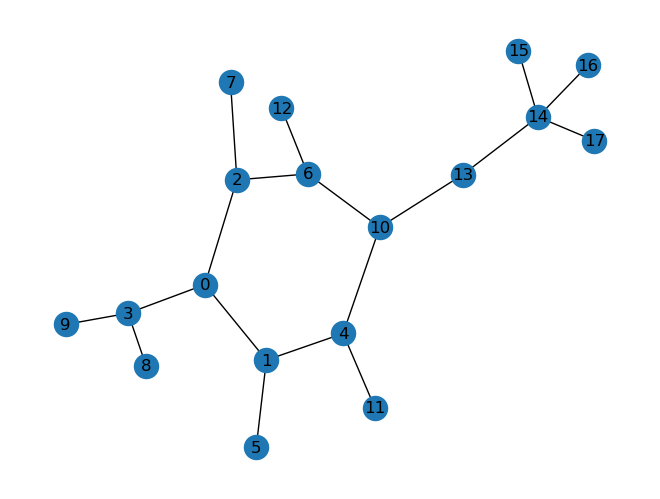

In [21]:
G = to_networkx(dataset_sorted[921], to_undirected=True, edge_attrs=['edge_attr'], node_attrs=['x'])
nx.draw(G, with_labels=True)

print(nx.number_connected_components(G))

In [75]:
min_motif_size = 2
max_motif_size = 2

In [67]:
### Estimate running time for different inputs ###
prev_nodes = -1
prev_edges = -1
num_nodes = []
num_edges = []
runtimes = []
for i in tqdm(range(len(dataset))):
    data = dataset_sorted[i]
    G = dataset_nx_sorted[i]
    if (data.num_nodes != prev_nodes) or (data.num_undirected_edges != prev_edges):
        # G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
        start = time.time()
        _, _ = get_all_connected_subgraphs(G, min_motif_size, max_motif_size)
        end = time.time()
        elapsed = end - start  # seconds

        num_nodes.append(data.num_nodes)
        num_edges.append(data.num_undirected_edges)
        runtimes.append(elapsed)
        
        prev_nodes = data.num_nodes
        prev_edges = data.num_undirected_edges

# min_subset = dataset_sorted[0:10]

# middle = len(dataset) // 2
# median_subset = dataset_sorted[middle:middle+10]

# max_subset = 

100%|██████████| 4337/4337 [00:03<00:00, 1198.57it/s]


In [69]:
print(num_nodes)
print(num_edges)
print(runtimes)

[4, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48,

In [70]:
# Save runtimes to CSV
df = pd.DataFrame({
    'num_nodes': num_nodes,
    'num_edges': num_edges,
    'runtime_seconds': runtimes
})

# Save the DataFrame to a CSV file without the index
df.to_csv(f'./experiments/runtimes_minmotif={min_motif_size}_maxmotif={max_motif_size}.csv', index=False)

In [80]:
df = pd.read_csv(f'./experiments/subgraph_enumeration/runtimes_minmotif={min_motif_size}_maxmotif={max_motif_size}.csv')

num_nodes = df['num_nodes']
num_edges = df['num_edges']
runtimes = df['runtime_seconds']

print(f'Loaded data for runtimes with minmotif={min_motif_size}, maxmotif={max_motif_size}')

Loaded data for runtimes with minmotif=2, maxmotif=2


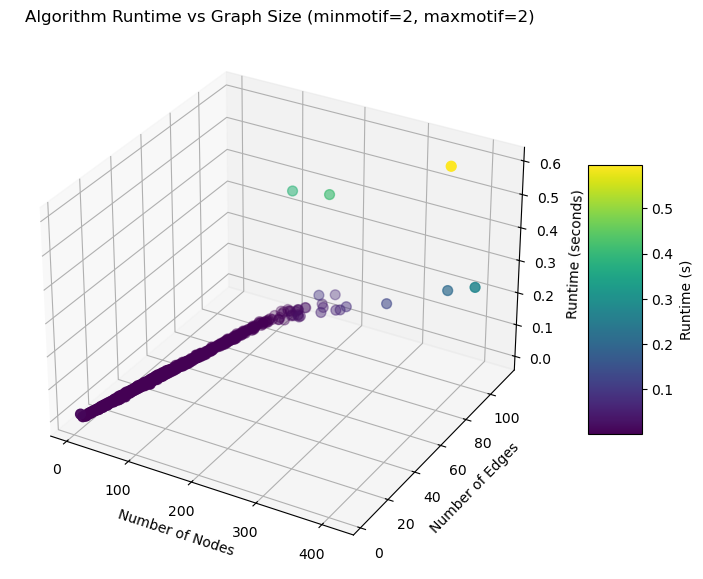

In [72]:
# Example data: Replace these lists with your actual data
x = num_nodes
y = num_edges
z = runtimes

# Create a new figure for the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
scatter = ax.scatter(x, y, z, 
                     c=runtimes,  # Color by runtime
                     cmap='viridis',  # Choose a colormap
                     s=50)  # Size of points

# Set labels for each axis
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Number of Edges')
ax.set_zlabel('Runtime (seconds)')
ax.set_title(f'Algorithm Runtime vs Graph Size (minmotif={min_motif_size}, maxmotif={max_motif_size})')

# Optionally add a color bar to indicate the mapping from runtime to color
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Runtime (s)')

plt.savefig(f'./experiments/runtimes_minmotif={min_motif_size}_maxmotif={max_motif_size}')
plt.show()

Using the histogram, let's use these runtimes for each unique combination of num nodes and edges to estimate the runtime on the entire dataset.

In [81]:
node_counts = [data.num_nodes for data in dataset_sorted]  # nodes
edge_counts = [data.num_undirected_edges for data in dataset_sorted]  # edges
counts, bins_nodes, bins_edges = np.histogram2d(node_counts, edge_counts, bins=range(0, max(max(node_counts), max(edge_counts)) + 2))

In [86]:
# Estimate the running time
total_runtime = 0  # seconds
for i in range(len(runtimes)):
    count = counts[node_counts[i], edge_counts[i]]
    total_runtime += runtimes[i] * count

total_runtime / 60

np.float64(2.0961792707443108)

### Compute on Dataset

Computing on dataset (or subset).

In [61]:
# Let's try computing on subset of dataset
motifs_in_dataset = []
for G in tqdm(dataset_nx):
    # G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    _, motifs = get_all_connected_subgraphs(G, min_motif_size, max_motif_size)
    motifs_in_dataset.append(motifs)

100%|██████████| 4337/4337 [00:04<00:00, 937.88it/s] 


In [87]:
len(motifs_in_dataset)
motifs

# Remove Duplicate Enumerated Subgraphs

In [79]:
# count = 0
# for motif_list in motifs_in_dataset:
#     count += len(motif_list)
# print(f'Count with duplicates: {count:,d}')
# print(motifs_in_dataset[0])

In [197]:
# Flatten list of dicts into one dict
keys = range(2, 4)
motif_dict_flattened = dict.fromkeys(keys, [])
for motif_dict in tqdm(motifs_in_dataset):
    for key in keys:
        motif_dict_flattened[key] = motif_dict_flattened[key] + (motif_dict[key])

  0%|          | 0/4337 [00:00<?, ?it/s]


TypeError: can only concatenate list (not "Graph") to list

In [21]:
# # Save dictionary to file
# import pickle
# with open('./experiments/motif_dict_flattened.pickle', 'wb') as handle:
#     pickle.dump(motif_dict_flattened, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# G = motif_dict_flattened[4][0]
# print(G.nodes.data())
# print(G.edges.data())

In [14]:
# Remove duplicates
unique_motifs = {}
for key in keys:
    unique = []
    subgraph_list = motif_dict_flattened[key]
    for sg in tqdm(subgraph_list):
        matched = False
        for uniq_sg in unique:
            if nx.is_isomorphic(sg, uniq_sg, node_match=node_match, edge_match=edge_match):
                matched = True
                break
        if matched == False:
            unique.append(sg)   
    unique_motifs[key] = unique

100%|██████████| 626/626 [00:00<00:00, 1631.18it/s]


In [15]:
count = 0
for key in keys:
    count += len(unique_motifs[key])
print(count)

49


Need to find a way to remove duplicates.

In [16]:
# # Subgraph Isomorphism checking throughout the dataset
# motif_to_check = motifs_in_dataset[1][100]
# print(motif_to_check)
# motif = G.subgraph(motif_to_check)
# nx.draw(motif_to_check, with_labels=True)

# motif_counts = []
# for data in tqdm(dataset):
#     G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
#     count, _ = count_node_induced_subgraph_isomorphisms(G, motif_to_check, use_v2=True)
#     motif_counts.append(count)

# Theoretical Estimates

In [ ]:
# Get list of number of nodes in each sample in the dataset
num_nodes = []
for data in dataset:
    num_nodes.append(data.num_nodes)

# Get average number of nodes in a graph in the dataset
avg_num_nodes = np.average(num_nodes)
print(avg_num_nodes)

30.317731150564907


In [ ]:
# Get list of number of edges in each sample in the dataset
num_edges = []
for data in dataset:
    num_edges.append(data.num_edges / 2)  # divide by two because each undirected edge is 2 directed edges in opposite directions

# Get average number of edges in a graph in the dataset
avg_num_edges = np.average(num_edges)
print(avg_num_edges)

30.76942587041734


In [10]:
# # Using the first sample in the dataset, time how long computation takes for one iteration
# data = dataset[0]
# G = to_networkx(data, to_undirected=True, edge_attrs=['edge_attr'], node_attrs=['x'])

# n = G.number_of_nodes()
# all_motifs = extract_all_motifs_in_graph(G, min_num_nodes_in_motif=2, max_num_nodes_in_motif=n-1)

The search space for querying for all possible motifs.

In [11]:
import math

# Best case scenario:
n = 14  # num of possible node features
e = 3  # num of possible edge features
V = 10  # num of nodes in graph (currently is the avg number of nodes in a graph in the dataset)
E = 9  # num of edges in graph (currently is the avg number of edges in a graph in the dataset)
min_nodes_in_motif = 2

val = 0
for k in range(min_nodes_in_motif, V):
    val += math.comb(V, k) * math.comb(n+k-1, k) * math.comb(e+(k-1)-1, k-1)

print(f'{val:,d}')

971,414,535


All possible motifs of certain size.

In [ ]:
n = 14  # num of possible node features
e = 3  # num of possible edge features
V = 10  # num of nodes in graph (currently is the avg number of nodes in a graph in the dataset)
E = 9  # num of edges in graph (currently is the avg number of edges in a graph in the dataset)


#### Counting certain functional groups (motifs with restrictions from chemistry)

Define motif to count in graphs

[(0, {'atoms': 'H'}), (2, {'atoms': 'N'}), (1, {'atoms': 'H'})]
[(0, 2, {'bonds': '1'}), (2, 1, {'bonds': '1'})]


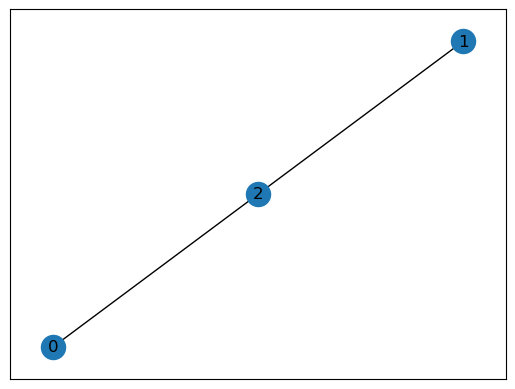

In [100]:
# NH2
edgelist = [(0, 2), (1, 2)]
NH2 = nx.Graph(edgelist)

NH2.nodes[0]['atoms'] = 'H'
NH2.nodes[1]['atoms'] = 'H'
NH2.nodes[2]['atoms'] = 'N'

NH2.edges[0, 2]['bonds'] = '1'
NH2.edges[1, 2]['bonds'] = '1'

print(NH2.nodes.data())
print(NH2.edges.data())
nx.draw_networkx(NH2, with_labels=True)

In [ ]:
# C6 ring
edgelist = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]
C6 = nx.Graph(edgelist)

for i in range(6):
    C6.nodes[i]['atoms'] = 'C'
    C6.edges[i, (i+1) % 6]['bonds'] = '1'

print(C6.nodes.data())
print(C6.edges.data())
nx.draw_networkx(C6, with_labels=True)

NameError: name 'nx' is not defined

Count motif in each sample in the dataset using "unique" counting algorithm.

In [102]:
nh2_counts = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    count, _ = count_node_induced_subgraph_isomorphisms(G, NH2, use_v2=True)
    nh2_counts.append(count)

100%|██████████| 4337/4337 [00:06<00:00, 664.77it/s]


In [103]:
c6_counts = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    count, _ = count_node_induced_subgraph_isomorphisms(G, C6, use_v2=True)
    c6_counts.append(count)

100%|██████████| 4337/4337 [00:14<00:00, 299.56it/s]


Count motif in each sample in the dataset using just networkx GraphMatcher, which will have some structural duplicates (just to compare runtime).

In [104]:
nh2_counts_alt = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    isomatcher = nx.isomorphism.GraphMatcher(G, NH2, node_match=node_match, edge_match=edge_match)
    count = len(list(isomatcher.subgraph_isomorphisms_iter()))
    nh2_counts_alt.append(count)

100%|██████████| 4337/4337 [00:05<00:00, 781.44it/s]


In [105]:
c6_counts_alt = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atoms'])
    isomatcher = nx.isomorphism.GraphMatcher(G, C6, node_match=node_match, edge_match=edge_match)
    count = len(list(isomatcher.subgraph_isomorphisms_iter()))
    c6_counts_alt.append(count)

100%|██████████| 4337/4337 [00:14<00:00, 303.87it/s]


It seems to take about half the time when just computing the pure subgraph isomorphisms, and not removing the duplicates.

Compute stats.

In [106]:
# Compare motif count to mutagenicity
mutagenicities = []
for data in dataset:
    mutagenicities.append(data.mutagenicity)
print(mutagenicities)

['mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'nonmutagen', 'mutagen', 'mutagen', 'mutagen', 'mutagen', 'nonmutagen', 'nonmutagen', 'mutagen', 'mutag

In [22]:
mutag_indices = [idx for idx, val in enumerate(mutagenicities) if val == 'mutagen']
nonmutag_indices = [idx for idx, val in enumerate(mutagenicities) if val == 'nonmutagen']

nh2_counts = np.array(nh2_counts)
c6_counts = np.array(c6_counts)

# NH2
mutag_nh2_counts = nh2_counts[mutag_indices]
nonmutag_nh2_counts = nh2_counts[nonmutag_indices]

# C6
mutag_c6_counts = c6_counts[mutag_indices]
nonmutag_c6_counts = c6_counts[nonmutag_indices]

In [23]:
nh2_counts = np.array(nh2_counts)
min_count = min(nh2_counts)
max_count = max(nh2_counts)

In [25]:
mutag_motif_counts = mutag_nh2_counts
nonmutag_motif_counts = nonmutag_nh2_counts

mutag_motif_counts = np.array(mutag_motif_counts)
mutag_hist = np.histogram(mutag_motif_counts, bins=range(min_count, max_count+2))
mutag_percents = [round(float(val / mutag_hist[0].sum()), 4) for val in mutag_hist[0]] 
print(f'Mutag hist: {mutag_hist}')
print(f'Mutag percents: {mutag_percents}')
print()

nonmutag_motif_counts = np.array(nonmutag_motif_counts)
nonmutag_hist = np.histogram(nonmutag_motif_counts, bins=range(min_count, max_count+2))
nonmutag_percents = [round(float(val / nonmutag_hist[0].sum()), 4) for val in nonmutag_hist[0]] 
print(f'Nonmutag hist: {nonmutag_hist}')
print(f'Nonmutag percents: {nonmutag_percents}')

Mutag hist: (array([1899,  359,  135,    4,    3,    1,    0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Mutag percents: [0.7909, 0.1495, 0.0562, 0.0017, 0.0012, 0.0004, 0.0]

Nonmutag hist: (array([1682,  209,   39,    4,    1,    0,    1]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Nonmutag percents: [0.8688, 0.108, 0.0201, 0.0021, 0.0005, 0.0, 0.0005]


Text(0, 0.5, 'Number of molecules')

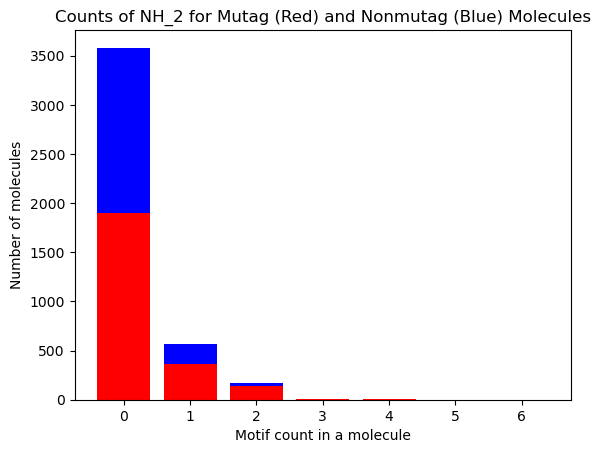

In [26]:
# NH2
fig, ax = plt.subplots()

x = range(min_count, max_count+1)
y_mutag = mutag_hist[0]
y_nonmutag = nonmutag_hist[0]

ax.bar(x, y_mutag, color='r')
ax.bar(x, y_nonmutag, bottom=y_mutag, color='b')
ax.set_title('Counts of NH_2 for Mutag (Red) and Nonmutag (Blue) Molecules')
ax.set_xlabel('Motif count in a molecule')
ax.set_ylabel('Number of molecules')

In [27]:
# C6
mutag_motif_counts = mutag_c6_counts
nonmutag_motif_counts = nonmutag_c6_counts

mutag_motif_counts = np.array(mutag_motif_counts)
mutag_hist = np.histogram(mutag_motif_counts, bins=range(min_count, max_count+2))
mutag_percents = [round(float(val / mutag_hist[0].sum()), 4) for val in mutag_hist[0]] 
print(f'Mutag hist: {mutag_hist}')
print(f'Mutag percents: {mutag_percents}')
print()

nonmutag_motif_counts = np.array(nonmutag_motif_counts)
nonmutag_hist = np.histogram(nonmutag_motif_counts, bins=range(min_count, max_count+2))
nonmutag_percents = [round(float(val / nonmutag_hist[0].sum()), 4) for val in nonmutag_hist[0]] 
print(f'Nonmutag hist: {nonmutag_hist}')
print(f'Nonmutag percents: {nonmutag_percents}')

Mutag hist: (array([2329,   61,    4,    6,    1,    0,    0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Mutag percents: [0.97, 0.0254, 0.0017, 0.0025, 0.0004, 0.0, 0.0]

Nonmutag hist: (array([1810,   73,   36,   14,    3,    0,    0]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Nonmutag percents: [0.9349, 0.0377, 0.0186, 0.0072, 0.0015, 0.0, 0.0]


Text(0, 0.5, 'Number of molecules')

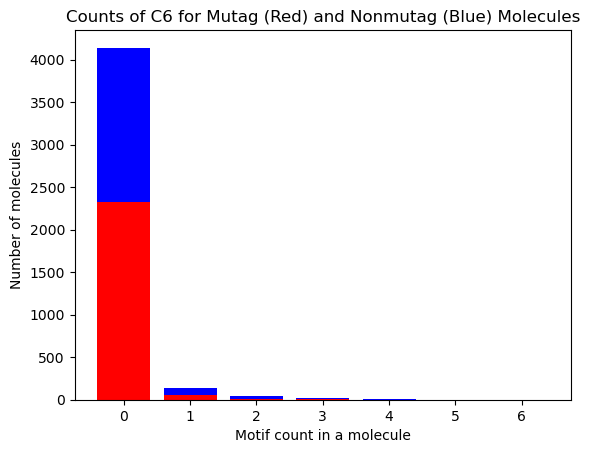

In [28]:
# C6
fig, ax = plt.subplots()

x = range(min_count, max_count+1)
y_mutag = mutag_hist[0]
y_nonmutag = nonmutag_hist[0]

ax.bar(x, y_mutag, color='r')
ax.bar(x, y_nonmutag, bottom=y_mutag, color='b')
ax.set_title('Counts of C6 for Mutag (Red) and Nonmutag (Blue) Molecules')
ax.set_xlabel('Motif count in a molecule')
ax.set_ylabel('Number of molecules')

# Dataset Statistics

In [29]:
# Class balance in dataset
mutag_count = 0
nonmutag_count = 0
for data in dataset:
    if data.mutagenicity == 'mutagen':
        mutag_count += 1
    elif data.mutagenicity == 'nonmutagen':
        nonmutag_count += 1

print(f'Mutagen count: {mutag_count}')
print(f'Nonmutagen count: {nonmutag_count}')

Mutagen count: 2401
Nonmutagen count: 1936


In [53]:
# Number of nodes vs edges for each sample in the graph
num_nodes = []
num_edges = []
for data in dataset:
    num_nodes.append(data.num_nodes)
    num_edges.append(int(data.num_edges / 2))

In [54]:
print(num_nodes)
print(num_edges)

[16, 72, 14, 36, 41, 11, 35, 8, 46, 50, 28, 16, 12, 42, 56, 17, 31, 14, 26, 13, 38, 39, 24, 22, 21, 33, 30, 48, 14, 24, 32, 26, 34, 20, 41, 10, 18, 62, 165, 11, 24, 29, 35, 18, 18, 27, 42, 22, 18, 30, 20, 17, 24, 27, 94, 25, 34, 44, 37, 26, 18, 45, 44, 35, 31, 22, 47, 26, 26, 23, 29, 30, 22, 35, 17, 38, 27, 48, 29, 31, 31, 12, 28, 34, 25, 19, 11, 64, 36, 39, 15, 40, 23, 53, 30, 32, 14, 8, 26, 26, 14, 47, 14, 39, 73, 68, 28, 26, 23, 44, 16, 27, 28, 13, 28, 43, 23, 18, 35, 25, 20, 42, 37, 24, 44, 32, 22, 57, 19, 18, 31, 69, 24, 106, 23, 27, 15, 22, 55, 16, 30, 60, 58, 38, 57, 60, 29, 17, 57, 26, 35, 31, 26, 15, 25, 17, 32, 5, 85, 27, 30, 68, 26, 19, 38, 24, 39, 75, 24, 21, 38, 20, 17, 36, 44, 45, 8, 73, 23, 25, 21, 36, 67, 31, 17, 42, 18, 17, 15, 14, 28, 18, 4, 28, 9, 20, 18, 12, 20, 23, 35, 37, 78, 44, 29, 12, 56, 20, 28, 29, 13, 26, 28, 20, 42, 15, 35, 24, 24, 78, 108, 15, 35, 22, 26, 35, 19, 18, 20, 19, 23, 46, 28, 34, 34, 58, 25, 31, 29, 15, 16, 33, 69, 13, 34, 15, 116, 20, 18, 35, 2

Text(0, 0.5, 'num edges')

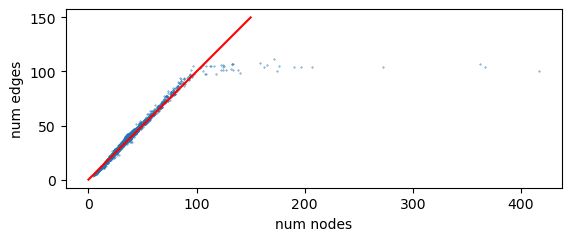

In [58]:
fig, ax = plt.subplots()
ax.scatter(num_nodes, num_edges, s=0.11)

x_one_to_one = np.linspace(0, 150, num=800)
y_one_to_one = np.linspace(0, 150, num=800)
ax.plot(x_one_to_one, y_one_to_one, color='r')

ax.set_aspect('equal')
ax.set_xlabel('num nodes')
ax.set_ylabel('num edges')

Histograms

Text(0, 0.5, 'Counts in dataset')

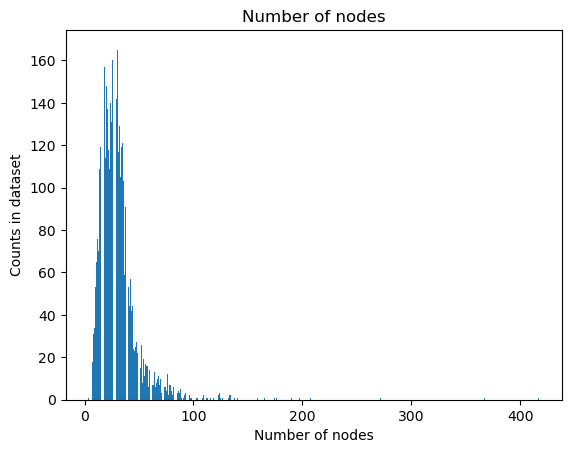

In [243]:
num_nodes = [data.num_nodes for data in dataset]

counts, bins = np.histogram(num_nodes, bins=range(min(num_nodes), max(num_nodes) + 2))

fig, ax = plt.subplots()
x = bins[:-1]
y = counts
ax.bar(x, y)

ax.set_title('Number of nodes')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Counts in dataset')

Text(0, 0.5, 'Counts in dataset')

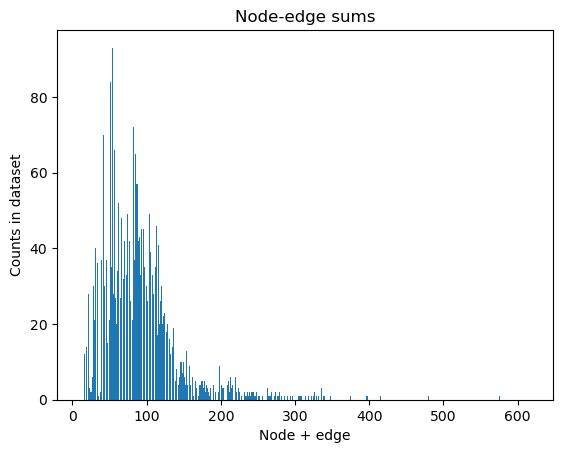

In [244]:
node_edge_sums = [(data.num_nodes + data.num_edges) for data in dataset]

counts, bins = np.histogram(node_edge_sums, bins=range(min(node_edge_sums), max(node_edge_sums) + 2))

fig, ax = plt.subplots()
x = bins[:-1]
y = counts
ax.bar(x, y)

ax.set_title('Node-edge sums')
ax.set_xlabel('Node + edge')
ax.set_ylabel('Counts in dataset')

In [95]:
counts, bins_x, bins_y = np.histogram2d([data.num_nodes for data in dataset],  # nodes
                                        [data.num_undirected_edges for data in dataset],  # edges
                                        bins=range(0, max(max(x), max(y)) + 2))

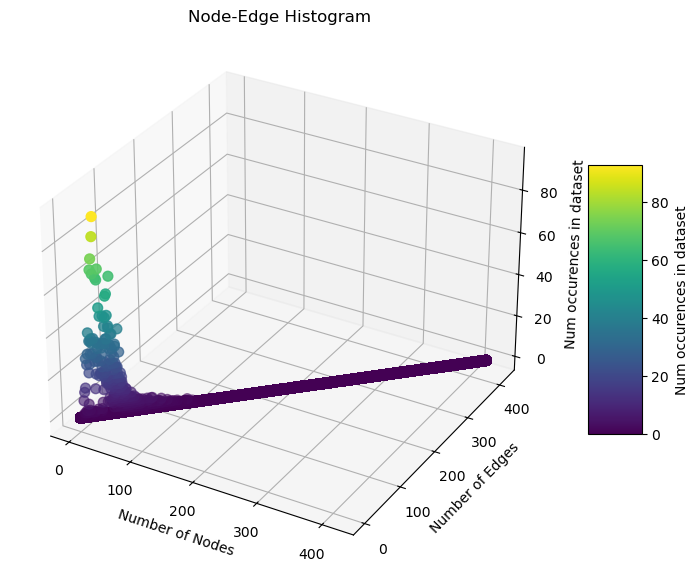

In [98]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = bins_x[:-1]  # nodes
y = bins_y[:-1]  # edges
z = counts

# Create a 3D scatter plot
scatter = ax.scatter(x, y, z, 
                     c=counts,  # Color by runtime
                     cmap='viridis',  # Choose a colormap
                     s=50)  # Size of points

# Set labels for each axis
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Number of Edges')
ax.set_zlabel('Num occurences in dataset')
ax.set_title(f'Node-Edge Histogram')

# Optionally add a color bar to indicate the mapping from runtime to color
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Num occurences in dataset')
plt.show()

Number of connected components

In [268]:
i = 0
idxs = []  # list containing idxs of data with not one connected component
num_con_comps = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['edge_attr'], node_attrs=['x'])
    num = nx.number_connected_components(G)
    if num != 1:
        idxs.append(i)
        num_con_comps.append(num)
    i += 1

100%|██████████| 4337/4337 [00:04<00:00, 999.63it/s] 


In [304]:
print(idxs)
print(num_con_comps)

[14, 38, 58, 93, 108, 112, 133, 138, 144, 145, 148, 166, 171, 182, 195, 206, 214, 220, 242, 246, 265, 268, 276, 277, 278, 286, 296, 302, 305, 309, 339, 357, 386, 397, 419, 425, 439, 457, 464, 470, 478, 497, 514, 518, 527, 560, 567, 637, 638, 640, 667, 672, 690, 706, 743, 770, 773, 783, 815, 839, 861, 872, 878, 902, 918, 952, 985, 1009, 1019, 1029, 1040, 1041, 1044, 1052, 1056, 1057, 1075, 1085, 1087, 1107, 1151, 1163, 1193, 1226, 1233, 1275, 1307, 1329, 1375, 1394, 1408, 1431, 1500, 1512, 1525, 1528, 1532, 1559, 1562, 1566, 1587, 1609, 1626, 1645, 1650, 1654, 1655, 1674, 1691, 1696, 1749, 1777, 1800, 1804, 1810, 1835, 1915, 1947, 1949, 1971, 1993, 2024, 2026, 2036, 2069, 2079, 2095, 2112, 2126, 2133, 2138, 2142, 2143, 2174, 2181, 2193, 2199, 2210, 2217, 2227, 2228, 2234, 2252, 2258, 2262, 2282, 2306, 2330, 2360, 2364, 2371, 2403, 2422, 2434, 2440, 2471, 2482, 2483, 2485, 2503, 2513, 2553, 2559, 2604, 2624, 2627, 2639, 2641, 2673, 2687, 2694, 2720, 2723, 2727, 2738, 2740, 2760, 2762, 27

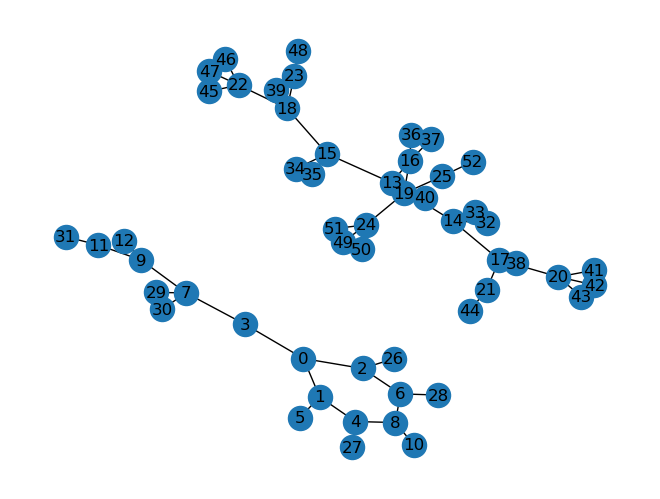

In [308]:
G = to_networkx(dataset[93], to_undirected=True, edge_attrs=['edge_attr'], node_attrs=['x'])
nx.draw(G, with_labels=True)

In [303]:
G.nodes()[55]

{'x': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

## Molecule Visualization

In [30]:
# from rdkit import Chem
# from rdkit.Chem import Draw

In [31]:
# def edge_label_to_rdkit_bond_type(edge_label):
#     if edge_label == '1':
#         return Chem.BondType.SINGLE
#     elif edge_label == '2':
#         return Chem.BondType.DOUBLE
#     elif edge_label == '3':
#         return Chem.BondType.TRIPLE
#     else:
#         raise Exception('Unknown edge label')

# #atom_mapping = get_node_feature_label_mapping()
# edge_mapping = get_edge_feature_label_mapping()
# bond_mapping = {}
# for val in edge_mapping.values():
#     bond_mapping[val] = edge_label_to_rdkit_bond_type(val)

# def visualize_molecule(data):
#     mol = Chem.RWMol()

#     for atom_symbol in data.atoms:
#         atom = Chem.Atom(atom_symbol)
#         mol.AddAtom(atom)
    
#     edge_index = data.edge_index
#     bonds = data.bonds
    
#     for i in range(len(bonds)):
#         start_atom = edge_index[0, i]
#         end_atom = edge_index[1, i]
#         bond_type = bond_mapping.get(bonds[i])
#         print(f'Start: {start_atom}, End: {end_atom}, Bond: {bond_type}')
#         mol.AddBond(int(start_atom), int(end_atom), bond_type)
    
#     mol = mol.GetMol()
#     img = Draw.MolToImage(mol, size=(300, 300))
#     return img

# img = visualize_molecule(data)
# img.show()